# Introduction

<font color='Black'>In this notebook, my main goal as a data scientist is to build a machine learning model that will provide useful information. More obviously, using the given dataset, I build a machine learning model that predicts whether an online customer of a retail shop will make their next purchase 90 days from the day they made their last purchase.</font>

In [208]:
'''import machine learning related libraries'''
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
import time

'''Import all required Libraries'''
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

'''Ignore deprecation and future, and user warnings.'''
import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = RuntimeWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 

'''Plotly visualization .'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
py.init_notebook_mode(connected = True)

'''Special Visualization'''
import missingno as msno
import networkx as nx

%matplotlib inline


In [209]:
'''Load the data'''
df = pd.read_csv('/kaggle/input/ecommerce-customerssales-record/Sales.csv')
df.head()

,index,CustomerID,TOTAL_ORDERS,REVENUE,AVERAGE_ORDER_VALUE,CARRIAGE_REVENUE,AVERAGESHIPPING,FIRST_ORDER_DATE,LATEST_ORDER_DATE,AVGDAYSBETWEENORDERS,...,WEEK3_DAY16_DAY23_REVENUE,WEEK4_DAY24_DAY31_REVENUE,TIME_0000_0600_ORDERS,TIME_0601_1200_ORDERS,TIME_1200_1800_ORDERS,TIME_1801_2359_ORDERS,TIME_0000_0600_REVENUE,TIME_0601_1200_REVENUE,TIME_1200_1800_REVENUE,TIME_1801_2359_REVENUE
0,0,2354,124,11986.54,96.67,529.59,4.27,2016-12-30,2021-10-24,14.19,...,2592.18,2409.71,12,61,37,14,1067.92,5674.65,3916.53,1327.44
1,1,2361,82,11025.96,134.46,97.92,1.19,2018-03-31,2021-10-24,15.89,...,2807.66,4106.19,1,13,24,44,30.25,3143.69,2205.47,5646.55
2,2,2415,43,7259.69,168.83,171.69,3.99,2017-11-30,2021-10-24,33.12,...,713.94,2861.90,0,6,12,25,0.00,707.98,2560.91,3990.80
3,3,2427,44,6992.27,158.92,92.82,2.11,2019-04-09,2021-10-24,21.11,...,997.02,1260.08,0,10,13,21,0.00,1908.99,2025.05,3058.23
4,4,2456,55,6263.44,113.88,179.04,3.26,2020-10-23,2021-10-24,6.65,...,2725.66,768.46,6,9,27,13,501.34,1197.83,3004.77,1559.50


In [210]:
# We store the parameters used in RFM analysis in new dataset
Rtl_data = df[['CustomerID','TOTAL_ORDERS','REVENUE','LATEST_ORDER_DATE','AVGDAYSBETWEENORDERS']]

In [211]:
Rtl_data.head()

,CustomerID,TOTAL_ORDERS,REVENUE,LATEST_ORDER_DATE,AVGDAYSBETWEENORDERS
0,2354,124,11986.54,2021-10-24,14.19
1,2361,82,11025.96,2021-10-24,15.89
2,2415,43,7259.69,2021-10-24,33.12
3,2427,44,6992.27,2021-10-24,21.11
4,2456,55,6263.44,2021-10-24,6.65


In [212]:
Rtl_data.max()

CustomerID                  279492
TOTAL_ORDERS                   156
REVENUE                    34847.4
LATEST_ORDER_DATE       2021-10-24
AVGDAYSBETWEENORDERS        1409.5
dtype: object

# Recency, Frequency, and Monetary (RFM) Score  
* Recency: How recently a customer has made a purchase
* Frequency: How often a customer makes a purchase
* Monetary Value: How much money a customer spends on purchases

**Highet RFM Score means customer is more loyal the customer is.**

<img src="https://d35fo82fjcw0y8.cloudfront.net/2018/03/01013508/Incontent_image.png" width="800">

#### **For Recency: We find the difference between Lastest date and date of last purchase**
* For Example: The is is purchased my last order on 22 october and last date on the record is 24 october then  my Recency Score is (24-22)=2

####  **For Frequency: We used the the data of the column 'AVGDAYSBETWEENORDERS'. The gap between each order is called Frequency**
* For Example: The is is purchased something very week that mean my frquency of order is 1 week or 7 days so  **Frequency Score=7**

####  **For Monetary: We Calculate the Total Revenue generated by that person**
* For Example: If I bought products of worth 20,000 from myntra in my life than my Monetary is 20,000  so **Monetary Score=20,000**

In [213]:
import datetime as dt

#Set Latest date 2011-12-10 as last invoice date was 2021-10-24. This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2021,10,24)

#Create RFM Modelling scores for each customer
RFMScores = Rtl_data.groupby('CustomerID').agg({'LATEST_ORDER_DATE': lambda x: (Latest_Date - pd.to_datetime(x.max())).days, 'AVGDAYSBETWEENORDERS': lambda x: int(x), 'REVENUE': lambda x: int(x)})

#Convert Invoice Date into type int
RFMScores['LATEST_ORDER_DATE'] = RFMScores['LATEST_ORDER_DATE'].astype(int)

#Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'LATEST_ORDER_DATE': 'Recency', 
                         'AVGDAYSBETWEENORDERS': 'Frequency', 
                         'REVENUE': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,2333,52,8,34847
1,2334,93,15,32486
2,2335,52,24,24178
3,2336,4,21,18554
4,2337,129,76,16884


# We plot each Row

## Recency Visualization

In [214]:
RFMScores.Recency.describe()

count    5000.000000
mean       86.420000
std        80.156513
min         0.000000
25%         6.000000
50%        67.000000
75%       170.250000
max       206.000000
Name: Recency, dtype: float64

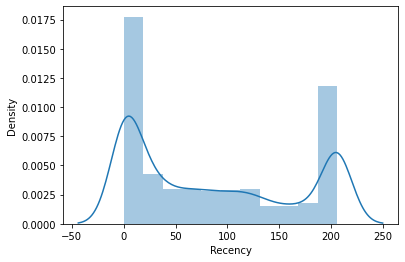

In [215]:
x = RFMScores['Recency']
ax = sns.distplot(x)

##  Frequency Visualization

In [216]:
RFMScores.Frequency.describe()

count    5000.000000
mean      162.777200
std       259.703254
min         0.000000
25%        21.000000
50%        57.000000
75%       170.000000
max      1409.000000
Name: Frequency, dtype: float64

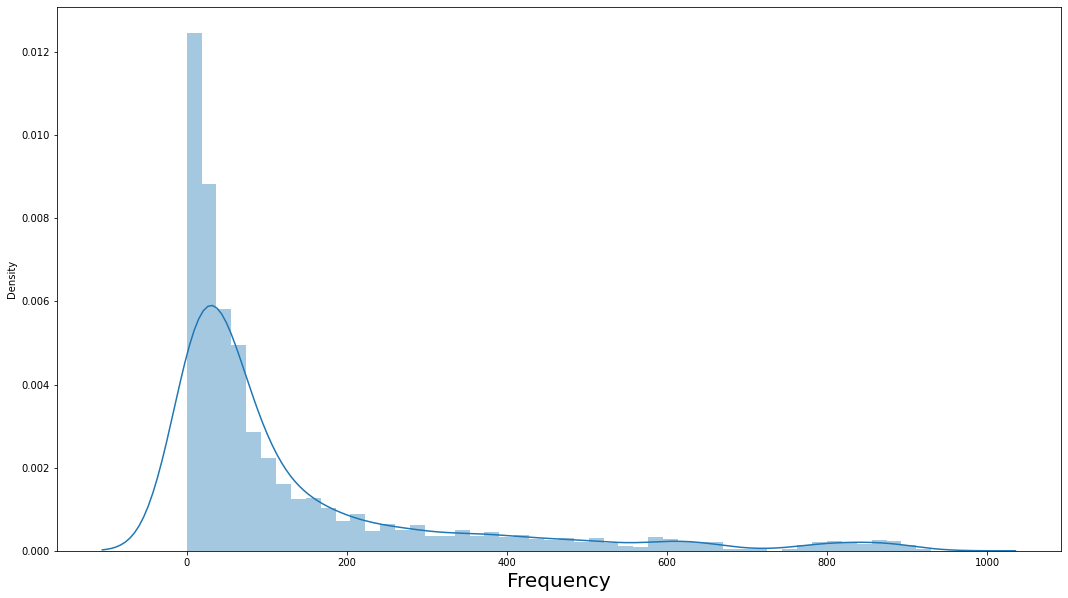

In [217]:
plt.rcParams['figure.figsize'] = (18, 10)
x = RFMScores.query('Frequency < 1000')['Frequency']
ax = sns.distplot(x = x)
ax.set_xlabel('Frequency', fontsize = 20)
plt.show()

**As we can see, we have a positiveley skewed data.**

# Monetary Visualization

In [218]:
RFMScores.Monetary.describe()

count     5000.000000
mean      1680.951600
std       1998.637336
min         38.000000
25%        315.000000
50%        966.000000
75%       2492.500000
max      34847.000000
Name: Monetary, dtype: float64

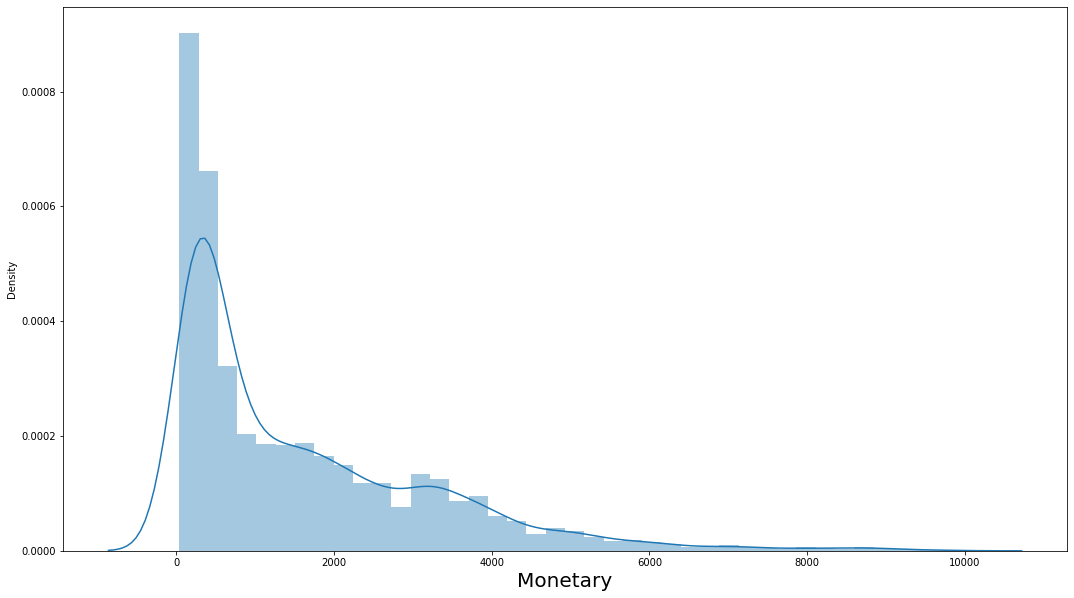

In [219]:
plt.rcParams['figure.figsize'] = (18, 10)
x = RFMScores.query('Monetary < 10000')['Monetary']
ax = sns.distplot(x = x)
ax.set_xlabel('Monetary', fontsize = 20)
plt.show()

**The same thing again, we have a positiveley skewed data for Monetary.**

# Let's split the values in 4 groups
* 0-25%
* 25%-50%
* 50%-80%
* 80%-100%


In [220]:
quantiles = RFMScores.quantile(q=[0.25,0.5,0.80])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 6.0, 0.5: 67.0, 0.8: 206.0},
 'Frequency': {0.25: 21.0, 0.5: 57.0, 0.8: 235.0},
 'Monetary': {0.25: 315.0, 0.5: 966.0, 0.8: 3026.2000000000003}}

**We can see the values on each cutting point.**

# Define a function to give score (Note: Low RFM is concidered Good)
* For example for below .25 revenue generator will get the score of 1
* 25-50 will get score of 2 and so on..
* Process will be similiar for Revenue and Frequency (higher the value lower the score)
* But for Recency it will be opposite (lower the Recency lower the score)

In [221]:
'''We should give low score to low Recency value.'''
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.80]: 
        return 3
    else:
        return 4
'''For Frequewncy and Monetary, higher the value lower the score'''
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.80]: 
        return 2
    else:
        return 1

In [222]:
'''Calling each function with the arguments'''
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
2333,52,8,34847,2,4,1
2334,93,15,32486,3,4,1
2335,52,24,24178,2,3,1
2336,4,21,18554,1,4,1
2337,129,76,16884,3,2,1


## Get the Total RFM score by adding all columns

In [223]:
'''Calculate and Add RFMGroup value column showing combined concatenated score of RFM'''
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

'''Calculate and Add RFMScore value column showing total sum of RFMGroup values'''
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
2333,52,8,34847,2,4,1,241,7
2334,93,15,32486,3,4,1,341,8
2335,52,24,24178,2,3,1,231,6
2336,4,21,18554,1,4,1,141,6
2337,129,76,16884,3,2,1,321,6


## Visualization of the distribution

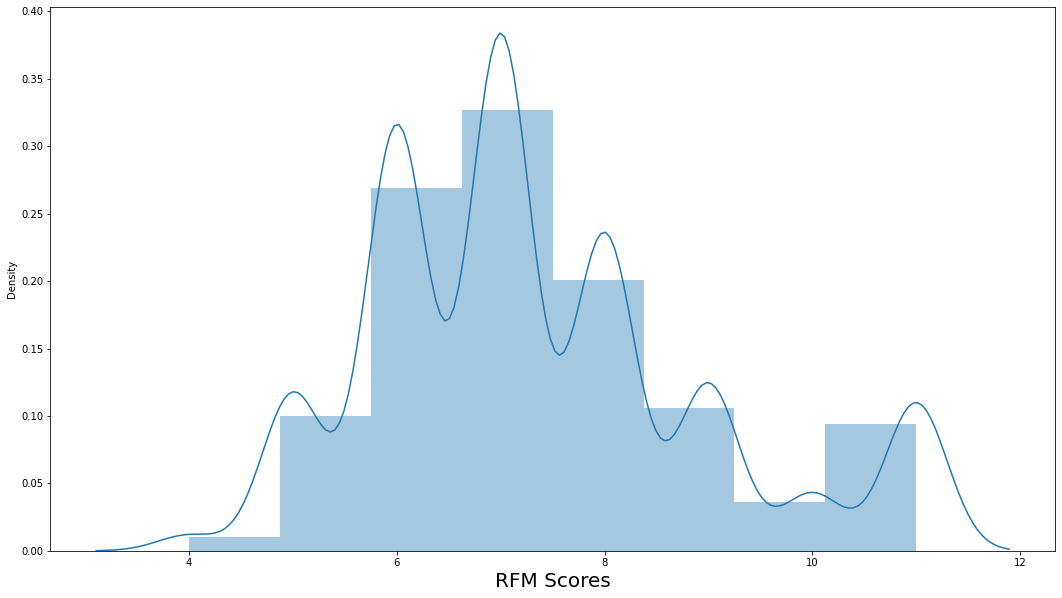

In [224]:
plt.rcParams['figure.figsize'] = (18, 10)
ax = sns.distplot(RFMScores['RFMScore'], bins=8)
ax.set_xlabel('RFM Scores', fontsize = 20)
plt.show()

# Lower the RFM.. More loyal user yor are
That means that having low RFM is good so we will define a function and for all users having low values we will assign them platinum badge

And for user having highest score we'll asign them Bronze Badge

In [225]:
'''lets give the segments a group name'''
def handel_badge(value):
    if(value>=10):
        return 'Bronze'
    elif(value>=8 and value<10):
        return 'Silver'
    elif(value>=6 and value<8):
        return 'Gold'
    else:
        return 'Platinum'

# Storing all the values in a list   
list1=RFMScores['RFMScore'].apply(handel_badge)
list1

CustomerID
2333        Gold
2334      Silver
2335        Gold
2336        Gold
2337        Gold
           ...  
251041      Gold
251042    Silver
261374    Silver
268356    Silver
279492      Gold
Name: RFMScore, Length: 5000, dtype: object

In [226]:
'''adding that list into the dataframe'''
RFMScores['RFM_Loyalty_Level']=list1

In [227]:
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,2333,52,8,34847,2,4,1,241,7,Gold
1,2334,93,15,32486,3,4,1,341,8,Silver
2,2335,52,24,24178,2,3,1,231,6,Gold
3,2336,4,21,18554,1,4,1,141,6,Gold
4,2337,129,76,16884,3,2,1,321,6,Gold


In [228]:
RFMScores['RFMScore'].min()

4

# Visualization of the distribution

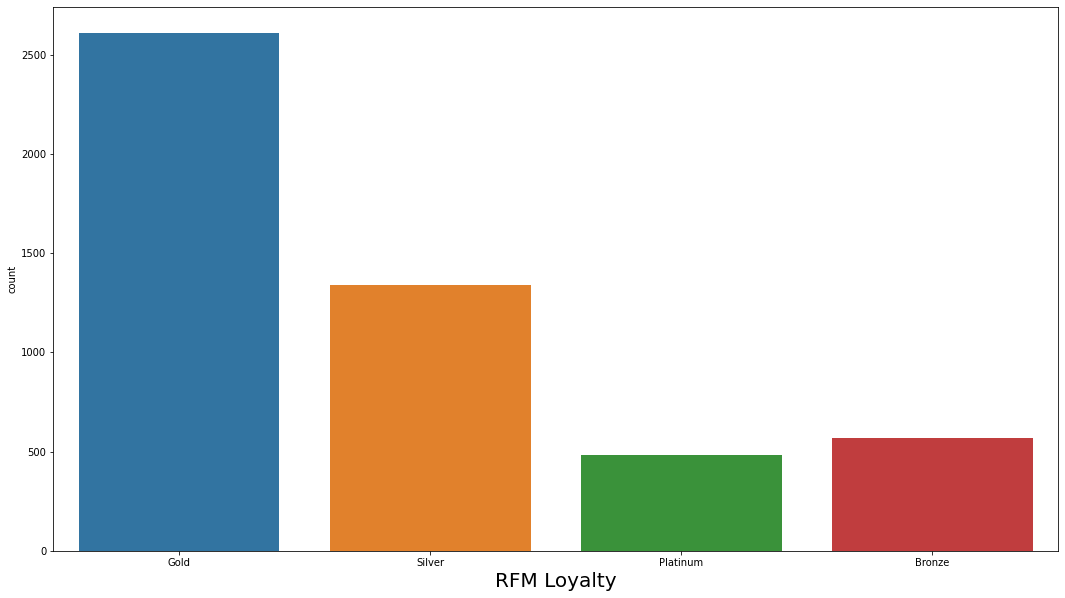

In [229]:
plt.rcParams['figure.figsize'] = (18, 10)
ax = sns.countplot(RFMScores['RFM_Loyalty_Level'])
ax.set_xlabel('RFM Loyalty', fontsize = 20)
plt.show()

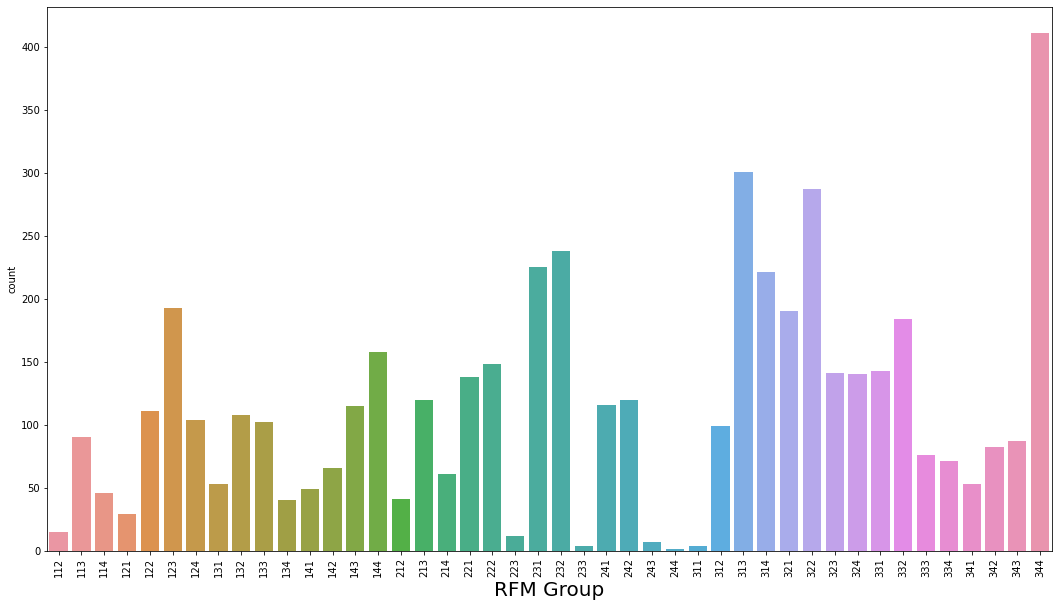

In [230]:
df2=RFMScores['RFMGroup'].sort_values(ascending=True)
plt.rcParams['figure.figsize'] = (18, 10)
ax = sns.countplot(df2)
ax.set_xlabel('RFM Group', fontsize = 20)
plt.xticks(rotation=90)
plt.show()

In [231]:
RFMScores['RFM_Loyalty_Level'].value_counts()

Gold        2608
Silver      1341
Bronze       570
Platinum     481
Name: RFM_Loyalty_Level, dtype: int64

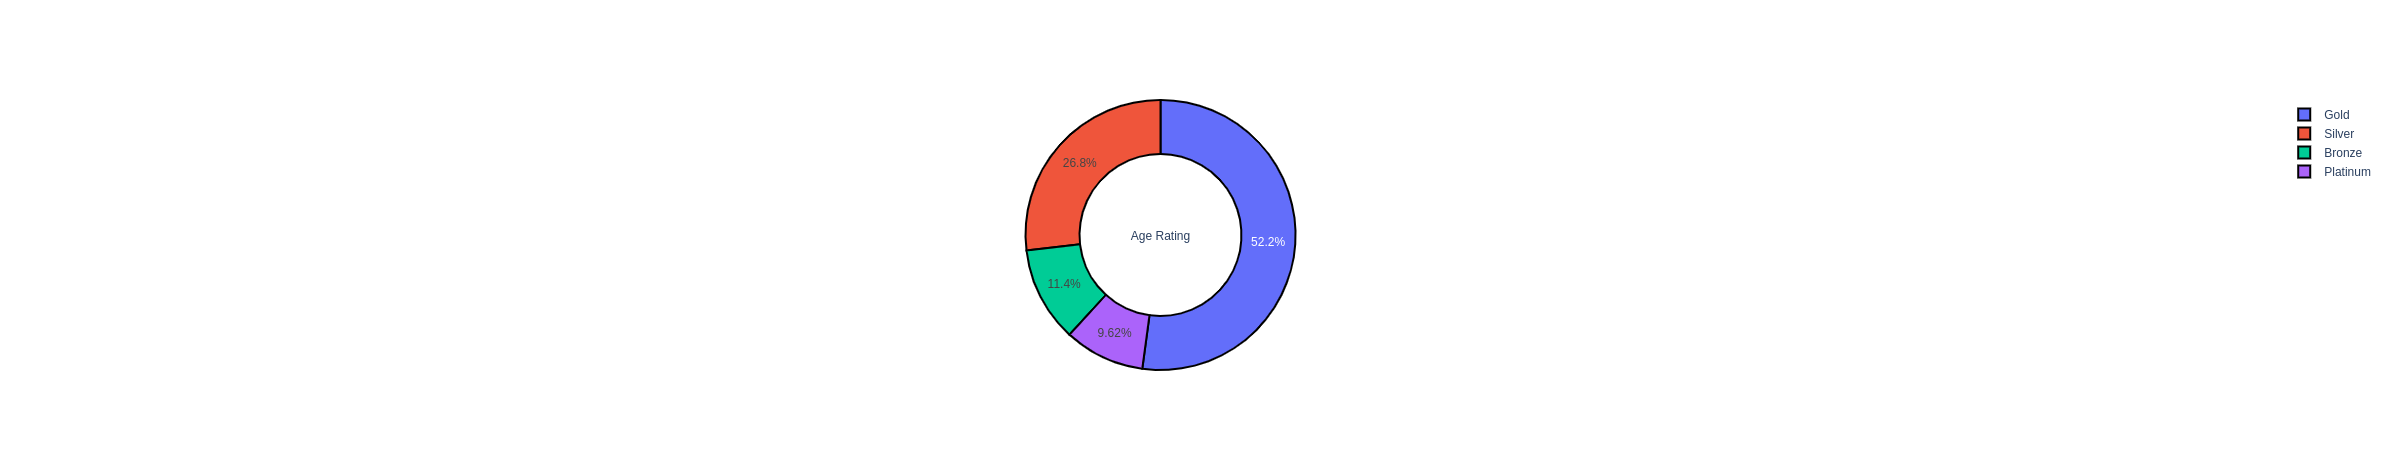

In [232]:
'''A Function To Plot Pie Plot using Plotly'''

def pie_plot(cnt_srs, colors, title):
    labels=cnt_srs.index
    values=cnt_srs.values
    trace = go.Pie(labels=labels, 
                   values=values, 
                   title=title, 
                   hoverinfo='percent+value', 
                   textinfo='percent',
                   textposition='inside',
                   hole=0.6,
                   showlegend=True,
                   marker=dict(colors=colors,line=dict(color='#000000',width=2),
                  )
              )
    return trace

py.iplot([pie_plot(list1.value_counts(), colors, 'Age Rating')])

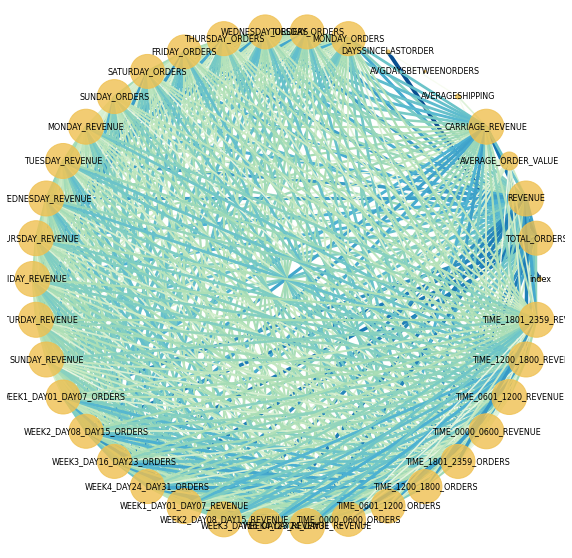

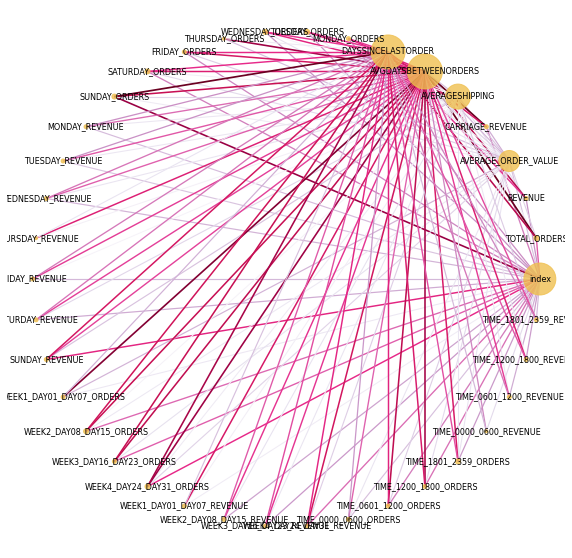

In [233]:
df_corr = df.drop('CustomerID', axis=1)
corr = df_corr.corr()
stocks = corr.index.values
cor_matrix = np.asmatrix(corr)
G = nx.from_numpy_matrix(cor_matrix)
G = nx.relabel_nodes(G,lambda x: stocks[x])
G.edges(data=True)

def create_corr_network(G, corr_direction, min_correlation):
    H = G.copy()
    for stock1, stock2, weight in G.edges(data=True):
        if corr_direction == "positive":
            if weight["weight"] <0 or weight["weight"] < min_correlation:
                H.remove_edge(stock1, stock2)
        else:
            if weight["weight"] >=0 or weight["weight"] > min_correlation:
                H.remove_edge(stock1, stock2)
                
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    weights = tuple([(1+abs(x))**2 for x in weights])
    d = nx.degree(H)
    nodelist, node_sizes = zip(*d)
    positions=nx.circular_layout(H)
    
    plt.figure(figsize=(10,10), dpi=72)

    nx.draw_networkx_nodes(H,positions,node_color='#EFC050',nodelist=nodelist,
                           node_size=tuple([x**2 for x in node_sizes]),alpha=0.8)
    
    nx.draw_networkx_labels(H, positions, font_size=8, 
                            font_family='sans-serif')
    
    if corr_direction == "positive": edge_colour = plt.cm.GnBu 
    else: edge_colour = plt.cm.PuRd
        
    nx.draw_networkx_edges(H, positions, style='solid',
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))
    plt.axis('off')
    plt.show() 

create_corr_network(G, 'positive', 0.1)
create_corr_network(G, 'negative', -0.001)

In [234]:
df.drop('index', axis=1, inplace=True)
df

,CustomerID,TOTAL_ORDERS,REVENUE,AVERAGE_ORDER_VALUE,CARRIAGE_REVENUE,AVERAGESHIPPING,FIRST_ORDER_DATE,LATEST_ORDER_DATE,AVGDAYSBETWEENORDERS,DAYSSINCELASTORDER,...,WEEK3_DAY16_DAY23_REVENUE,WEEK4_DAY24_DAY31_REVENUE,TIME_0000_0600_ORDERS,TIME_0601_1200_ORDERS,TIME_1200_1800_ORDERS,TIME_1801_2359_ORDERS,TIME_0000_0600_REVENUE,TIME_0601_1200_REVENUE,TIME_1200_1800_REVENUE,TIME_1801_2359_REVENUE
0,2354,124,11986.54,96.67,529.59,4.27,2016-12-30,2021-10-24,14.19,1,...,2592.18,2409.71,12,61,37,14,1067.92,5674.65,3916.53,1327.44
1,2361,82,11025.96,134.46,97.92,1.19,2018-03-31,2021-10-24,15.89,1,...,2807.66,4106.19,1,13,24,44,30.25,3143.69,2205.47,5646.55
2,2415,43,7259.69,168.83,171.69,3.99,2017-11-30,2021-10-24,33.12,1,...,713.94,2861.90,0,6,12,25,0.00,707.98,2560.91,3990.80
3,2427,44,6992.27,158.92,92.82,2.11,2019-04-09,2021-10-24,21.11,1,...,997.02,1260.08,0,10,13,21,0.00,1908.99,2025.05,3058.23
4,2456,55,6263.44,113.88,179.04,3.26,2020-10-23,2021-10-24,6.65,1,...,2725.66,768.46,6,9,27,13,501.34,1197.83,3004.77,1559.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,176278,1,117.49,117.49,4.99,4.99,2021-04-01,2021-04-01,0.00,207,...,0.00,0.00,0,0,0,1,0.00,0.00,0.00,117.49
4996,176319,1,117.49,117.49,4.99,4.99,2021-04-01,2021-04-01,0.00,207,...,0.00,0.00,0,0,0,1,0.00,0.00,0.00,117.49
4997,176336,1,117.49,117.49,4.99,4.99,2021-04-01,2021-04-01,0.00,207,...,0.00,0.00,0,0,0,1,0.00,0.00,0.00,117.49
4998,176370,1,117.49,117.49,4.99,4.99,2021-04-01,2021-04-01,0.00,207,...,0.00,0.00,0,0,1,0,0.00,0.00,117.49,0.00


In [235]:
merged = pd.merge(df,RFMScores,on='CustomerID',how='left')
# merged.sort_values('Frequency',ascending=False)
merged['NextPurchaseDayRange'] = 1
merged

,CustomerID,TOTAL_ORDERS,REVENUE,AVERAGE_ORDER_VALUE,CARRIAGE_REVENUE,AVERAGESHIPPING,FIRST_ORDER_DATE,LATEST_ORDER_DATE,AVGDAYSBETWEENORDERS,DAYSSINCELASTORDER,...,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,NextPurchaseDayRange
0,2354,124,11986.54,96.67,529.59,4.27,2016-12-30,2021-10-24,14.19,1,...,0,14,11986,1,4,1,141,6,Gold,1
1,2361,82,11025.96,134.46,97.92,1.19,2018-03-31,2021-10-24,15.89,1,...,0,15,11025,1,4,1,141,6,Gold,1
2,2415,43,7259.69,168.83,171.69,3.99,2017-11-30,2021-10-24,33.12,1,...,0,33,7259,1,3,1,131,5,Platinum,1
3,2427,44,6992.27,158.92,92.82,2.11,2019-04-09,2021-10-24,21.11,1,...,0,21,6992,1,4,1,141,6,Gold,1
4,2456,55,6263.44,113.88,179.04,3.26,2020-10-23,2021-10-24,6.65,1,...,0,6,6263,1,4,1,141,6,Gold,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,176278,1,117.49,117.49,4.99,4.99,2021-04-01,2021-04-01,0.00,207,...,206,0,117,3,4,4,344,11,Bronze,1
4996,176319,1,117.49,117.49,4.99,4.99,2021-04-01,2021-04-01,0.00,207,...,206,0,117,3,4,4,344,11,Bronze,1
4997,176336,1,117.49,117.49,4.99,4.99,2021-04-01,2021-04-01,0.00,207,...,206,0,117,3,4,4,344,11,Bronze,1
4998,176370,1,117.49,117.49,4.99,4.99,2021-04-01,2021-04-01,0.00,207,...,206,0,117,3,4,4,344,11,Bronze,1


In [236]:
merged.loc[merged.Frequency>90, 'NextPurchaseDayRange'] = 0
merged

,CustomerID,TOTAL_ORDERS,REVENUE,AVERAGE_ORDER_VALUE,CARRIAGE_REVENUE,AVERAGESHIPPING,FIRST_ORDER_DATE,LATEST_ORDER_DATE,AVGDAYSBETWEENORDERS,DAYSSINCELASTORDER,...,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,NextPurchaseDayRange
0,2354,124,11986.54,96.67,529.59,4.27,2016-12-30,2021-10-24,14.19,1,...,0,14,11986,1,4,1,141,6,Gold,1
1,2361,82,11025.96,134.46,97.92,1.19,2018-03-31,2021-10-24,15.89,1,...,0,15,11025,1,4,1,141,6,Gold,1
2,2415,43,7259.69,168.83,171.69,3.99,2017-11-30,2021-10-24,33.12,1,...,0,33,7259,1,3,1,131,5,Platinum,1
3,2427,44,6992.27,158.92,92.82,2.11,2019-04-09,2021-10-24,21.11,1,...,0,21,6992,1,4,1,141,6,Gold,1
4,2456,55,6263.44,113.88,179.04,3.26,2020-10-23,2021-10-24,6.65,1,...,0,6,6263,1,4,1,141,6,Gold,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,176278,1,117.49,117.49,4.99,4.99,2021-04-01,2021-04-01,0.00,207,...,206,0,117,3,4,4,344,11,Bronze,1
4996,176319,1,117.49,117.49,4.99,4.99,2021-04-01,2021-04-01,0.00,207,...,206,0,117,3,4,4,344,11,Bronze,1
4997,176336,1,117.49,117.49,4.99,4.99,2021-04-01,2021-04-01,0.00,207,...,206,0,117,3,4,4,344,11,Bronze,1
4998,176370,1,117.49,117.49,4.99,4.99,2021-04-01,2021-04-01,0.00,207,...,206,0,117,3,4,4,344,11,Bronze,1


In [237]:
RFMScores['Frequency'].describe()

count    5000.000000
mean      162.777200
std       259.703254
min         0.000000
25%        21.000000
50%        57.000000
75%       170.000000
max      1409.000000
Name: Frequency, dtype: float64

In [238]:
merged['FIRST_ORDER_DATE'] = pd.to_datetime(merged['FIRST_ORDER_DATE'])
merged['LATEST_ORDER_DATE'] = pd.to_datetime(merged['LATEST_ORDER_DATE'])
merged['RFMGroup'] = merged['RFMGroup'].astype(str).astype(int)

In [239]:
merged = merged.drop(['FIRST_ORDER_DATE','LATEST_ORDER_DATE','Frequency','RFM_Loyalty_Level'], axis=1)

In [240]:
X, y = merged.drop('NextPurchaseDayRange', axis=1), merged.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None, shuffle=True)

In [241]:
parameter = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(1,5,2)
    }

p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), 
                             param_grid = parameter, 
                             scoring='accuracy', 
                             n_jobs=-1, 
                             #iid=False, 
                             cv=2
                            )

p_grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     m

In [242]:
p_grid_search.best_params_, p_grid_search.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.9994285714285714)

In [243]:
refined_xgb_model = xgb.XGBClassifier(eval_metric='logloss', 
                                      max_depth=list(p_grid_search.best_params_.values())[0]-1, 
                                      min_child_weight=list(p_grid_search.best_params_.values())[-1]+4
                                     ).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'.format(refined_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(refined_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 1.00


In [244]:
ref_xgb_pred_y = refined_xgb_model.predict(X_test)

In [245]:
log_reg_pred_y = LogisticRegression().fit(X_train, y_train).predict(X_test)

In [246]:
def get_confusion_matrix(y_test, y_pred):
    """
    Displays the confusion matrix of the input numpy arrays y_test and y_pred.
    
    INPUT: 
        y_test - A numpy array 
        y_pred - A numpy array
        
    OUTPUT:
        NoneType
    """
    
    data = {'y_Actual': y_test, 'y_Predicted': y_pred}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                              rownames=['Actual'], 
                              colnames=['Predicted'])
    
    sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap="Spectral")
    plt.show()

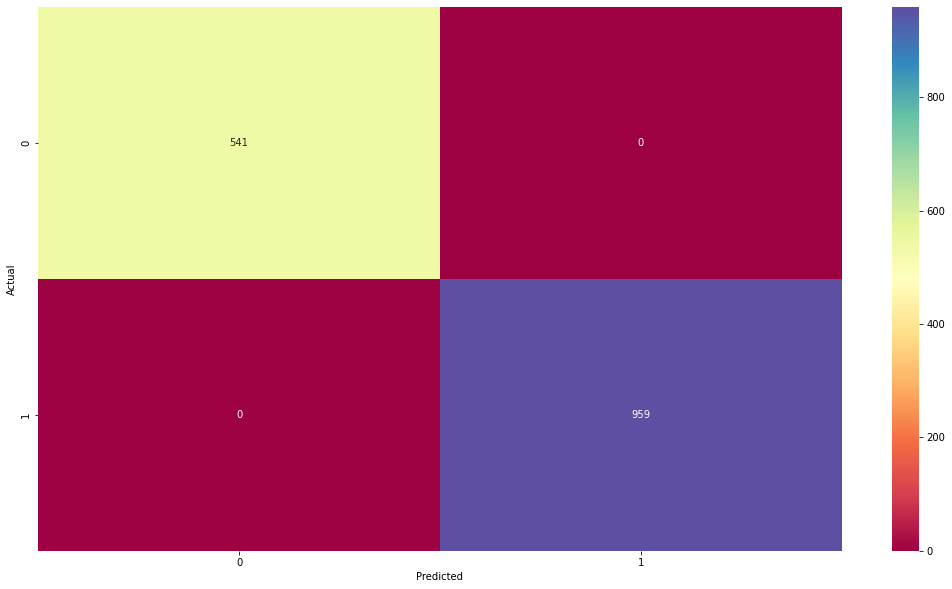

In [247]:
get_confusion_matrix(np.array(y_test), ref_xgb_pred_y)

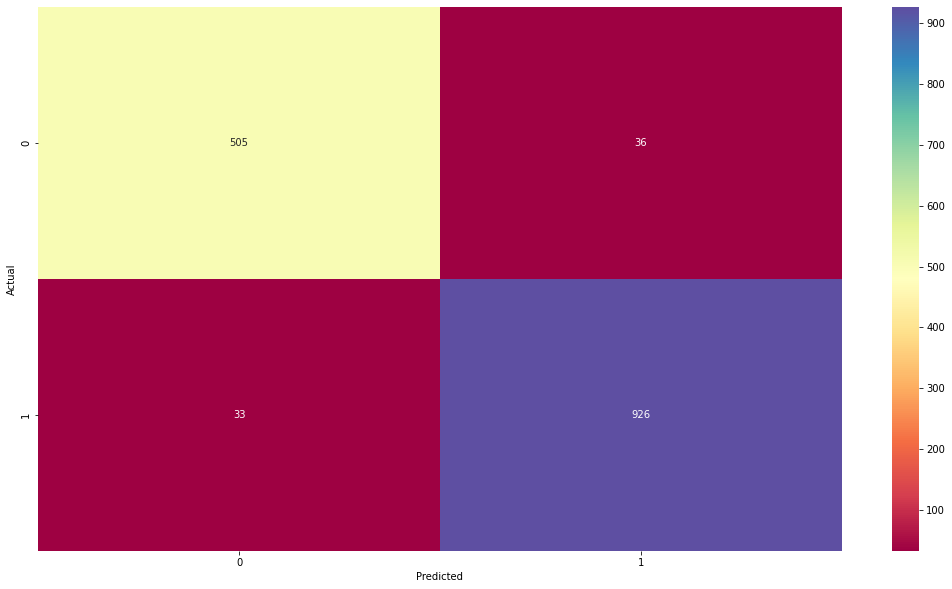

In [248]:
get_confusion_matrix(np.array(y_test), log_reg_pred_y)

**This seems like a great predictor for this project.**

![](https://media0.giphy.com/media/lFjHs5txoK50Y/giphy.gif?cid=ecf05e47ek8tohka3zlpvsmu63r29rwy2rq2dzbvfi2mj0uh&rid=giphy.gif&ct=g)

# <font color='Black'>If you find my kernel helpful please upvote and give me your feedback!</font>